## Hyperspectral Image Segmentation by Convolutional Neural Network 

### standardized spectra at full resolution without spatial dimension

### training on north facing image and testing on two south facing

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Kmeans Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN Trained on North Facing Image

In [8]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

reading and parsing ../../image_files/scan1_slow_roof_VNIR.hdr...
reading ../../image_files/scan1_slow_roof_VNIR.raw...


In [9]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

(872, 1600, 1247)


In [10]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

(1995200, 872)


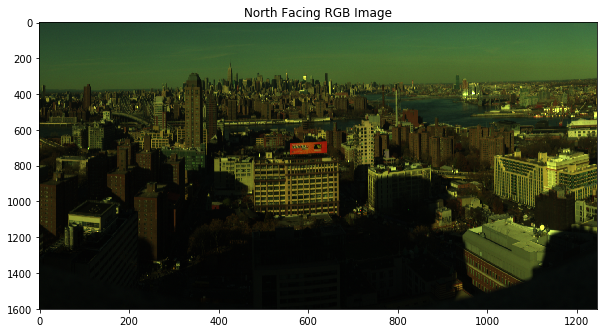

In [11]:
cube_norm_north = (cube_reshaped_north - cube_reshaped_north.min()) / (cube_reshaped_north.max() - cube_reshaped_north.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind_n = (np.abs(cube_north.waves - 650.0)).argmin()
green_ind_n = (np.abs(cube_north.waves - 550.0)).argmin()
blue_ind_n = (np.abs(cube_north.waves - 450.0)).argmin()

cube_reshaped_north2 = cube_norm_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])
cube_scene_north = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing RGB Image')
ax.imshow(cube_scene_north, aspect=0.4)
plt.show()

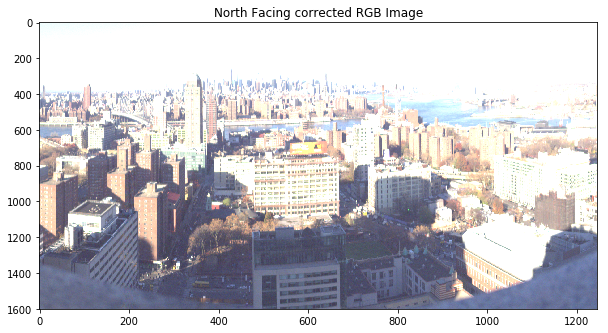

In [12]:
rgbn = cube_reshaped_north2[:, :, [red_ind_n, green_ind_n, blue_ind_n]].copy()
rgbn /= rgbn.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('North Facing corrected RGB Image')
ax.imshow(rgbn.clip(0, 1)**0.5, aspect=0.4)
plt.show()

In [13]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
cube_reshaped_north = cube_standard_north

In [14]:
print(len(cube_north.waves))
print(min(cube_north.waves), max(cube_north.waves))
print(cube_reshaped_north.shape)

872
400.46 1031.29
(1995200, 872)


#### Reading manually classified set for training and testing

In [15]:
# read manually selected coordinates files

#sky coordinates
sky_filen = open("../manual_classified_pixels/1_sky_coordinates_north.txt", "r")
sky_coordsn = sky_filen.readlines()
sky_filen.close()
sky_coordsn = np.array([point_from_string(line) for line in sky_coordsn])
print("sky:        ", sky_coordsn.shape)

#clouds coordinates
clouds_filen = open("../manual_classified_pixels/2_clouds_coordinates_north.txt", "r")
clouds_coordsn = clouds_filen.readlines()
clouds_filen.close()
clouds_coordsn = np.array([point_from_string(line) for line in clouds_coordsn])
print("clouds:     ", clouds_coordsn.shape)

#vegetation coordinates
veg_filen = open("../manual_classified_pixels/3_vegetation_coordinates_north.txt", "r")
veg_coordsn = veg_filen.readlines()
veg_filen.close()
veg_coordsn = np.array([point_from_string(line) for line in veg_coordsn])
print("vegetation: ", veg_coordsn.shape)

#water coordinates
wtr_filen = open("../manual_classified_pixels/4_water_coordinates_north.txt", "r")
wtr_coordsn = wtr_filen.readlines()
wtr_filen.close()
wtr_coordsn = np.array([point_from_string(line) for line in wtr_coordsn])
print("water:      ", wtr_coordsn.shape)

#buildings coordinates
blt_filen = open("../manual_classified_pixels/5_buildings_coordinates_north.txt", "r")
blt_coordsn = blt_filen.readlines()
blt_filen.close()
blt_coordsn = np.array([point_from_string(line) for line in blt_coordsn])
print("buildings:  ", blt_coordsn.shape)

#windows coordinates
windows_filen = open("../manual_classified_pixels/6_windows_coordinates_north.txt", "r")
windows_coordsn = windows_filen.readlines()
windows_filen.close()
windows_coordsn = np.array([point_from_string(line) for line in windows_coordsn])
print("windows:    ", windows_coordsn.shape)

#roads coordinates
rds_filen = open("../manual_classified_pixels/7_roads_coordinates_north.txt", "r")
rds_coordsn = rds_filen.readlines()
rds_filen.close()
rds_coordsn = np.array([point_from_string(line) for line in rds_coordsn])
print("road:       ", rds_coordsn.shape)

#cars coordinates
cars_filen = open("../manual_classified_pixels/8_cars_coordinates_north.txt", "r")
cars_coordsn = cars_filen.readlines()
cars_filen.close()
cars_coordsn = np.array([point_from_string(line) for line in cars_coordsn])
print("cars:       ", cars_coordsn.shape)

#metal coordinates
mtl_filen = open("../manual_classified_pixels/9_metal_coordinates_north.txt", "r")
mtl_coordsn = mtl_filen.readlines()
mtl_filen.close()
mtl_coordsn = np.array([point_from_string(line) for line in mtl_coordsn])
print("metal:      ", mtl_coordsn.shape)

sky:         (300, 2)
clouds:      (200, 2)
vegetation:  (700, 2)
water:       (620, 2)
buildings:   (1600, 2)
windows:     (600, 2)
road:        (250, 2)
cars:        (250, 2)
metal:       (185, 2)


#### split classified pixels into 80% training and 20% testing sets

In [16]:
import random

# sky coordinates
sky_indn = np.arange(sky_coordsn.shape[0])
random.Random(3).shuffle(sky_indn)
lim_ind = int(len(sky_indn)*0.8)
sky_train_indn = sky_indn[:lim_ind]
sky_test_indn = sky_indn[lim_ind:]
print("sky %d %d" % (len(sky_train_indn), len(sky_test_indn)))

# clouds coordinates
clouds_indn = np.arange(clouds_coordsn.shape[0])
random.Random(3).shuffle(clouds_indn)
lim_ind = int(len(clouds_indn)*0.8)
clouds_train_indn = clouds_indn[:lim_ind]
clouds_test_indn = clouds_indn[lim_ind:]
print("clouds %d %d" % (len(clouds_train_indn), len(clouds_test_indn)))

# vegetation coordinates
veg_indn = np.arange(veg_coordsn.shape[0])
random.Random(3).shuffle(veg_indn)
lim_ind = int(len(veg_indn)*0.8)
veg_train_indn = veg_indn[:lim_ind]
veg_test_indn = veg_indn[lim_ind:]
print("vegetation %d %d" % (len(veg_train_indn), len(veg_test_indn)))

# water coordinates
wtr_indn = np.arange(wtr_coordsn.shape[0])
random.Random(3).shuffle(wtr_indn)
lim_ind = int(len(wtr_indn)*0.8)
wtr_train_indn = wtr_indn[:lim_ind]
wtr_test_indn = wtr_indn[lim_ind:]
print("water %d %d" % (len(wtr_train_indn), len(wtr_test_indn)))

# built coordinates
blt_indn = np.arange(blt_coordsn.shape[0])
random.Random(3).shuffle(blt_indn)
lim_ind = int(len(blt_indn)*0.8)
blt_train_indn = blt_indn[:lim_ind]
blt_test_indn = blt_indn[lim_ind:]
print("built %d %d" % (len(blt_train_indn), len(blt_test_indn)))

# windows coordinates
windows_indn = np.arange(windows_coordsn.shape[0])
random.Random(3).shuffle(windows_indn)
lim_ind = int(len(windows_indn)*0.8)
windows_train_indn = windows_indn[:lim_ind]
windows_test_indn = windows_indn[lim_ind:]
print("windows %d %d" % (len(windows_train_indn), len(windows_test_indn)))

# roads coordinates
rds_indn = np.arange(rds_coordsn.shape[0])
random.Random(3).shuffle(rds_indn)
lim_ind = int(len(rds_indn)*0.8)
rds_train_indn = rds_indn[:lim_ind]
rds_test_indn = rds_indn[lim_ind:]
print("roads %d %d" % (len(rds_train_indn), len(rds_test_indn)))

# cars coordinates
cars_indn = np.arange(cars_coordsn.shape[0])
random.Random(3).shuffle(cars_indn)
lim_ind = int(len(cars_indn)*0.8)
cars_train_indn = cars_indn[:lim_ind]
cars_test_indn = cars_indn[lim_ind:]
print("cars %d %d" % (len(cars_train_indn), len(cars_test_indn)))

# metal coordinates
mtl_indn = np.arange(mtl_coordsn.shape[0])
random.Random(3).shuffle(mtl_indn)
lim_ind = int(len(mtl_indn)*0.8)
mtl_train_indn = mtl_indn[:lim_ind]
mtl_test_indn = mtl_indn[lim_ind:]
print("metal %d %d" % (len(mtl_train_indn), len(mtl_test_indn)))

sky 240 60
clouds 160 40
vegetation 560 140
water 496 124
built 1280 320
windows 480 120
roads 200 50
cars 200 50
metal 148 37


In [17]:
cube_std_reshapedn = cube_standard_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], cube_sub_north.shape[0])

In [18]:
cube_sky_trainn = cube_std_reshapedn[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
cube_sky_testn = cube_std_reshapedn[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
print("sky ", cube_sky_trainn.shape, cube_sky_testn.shape)

cube_clouds_trainn = cube_std_reshapedn[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
cube_clouds_testn = cube_std_reshapedn[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
print("clouds ", cube_clouds_trainn.shape, cube_clouds_testn.shape)

cube_veg_trainn = cube_std_reshapedn[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
cube_veg_testn = cube_std_reshapedn[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
print("vegetation ", cube_veg_trainn.shape, cube_veg_testn.shape)

cube_wtr_trainn = cube_std_reshapedn[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
cube_wtr_testn = cube_std_reshapedn[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
print("water ", cube_wtr_trainn.shape, cube_wtr_testn.shape)

cube_blt_trainn = cube_std_reshapedn[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
cube_blt_testn = cube_std_reshapedn[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
print("built ", cube_blt_trainn.shape, cube_blt_testn.shape)

cube_windows_trainn = cube_std_reshapedn[windows_coordsn[windows_train_indn[:], 0], windows_coordsn[windows_train_indn[:], 1], :]
cube_windows_testn = cube_std_reshapedn[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
print("windows ", cube_windows_trainn.shape, cube_windows_testn.shape)

cube_rds_trainn = cube_std_reshapedn[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
cube_rds_testn = cube_std_reshapedn[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
print("roads ", cube_rds_trainn.shape, cube_rds_testn.shape)

cube_cars_trainn = cube_std_reshapedn[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cube_cars_testn = cube_std_reshapedn[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
print("cars ", cube_cars_trainn.shape, cube_cars_testn.shape)

cube_mtl_trainn = cube_std_reshapedn[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
cube_mtl_testn = cube_std_reshapedn[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
print("metal ", cube_mtl_trainn.shape, cube_mtl_testn.shape)

sky  (240, 872) (60, 872)
clouds  (160, 872) (40, 872)
vegetation  (560, 872) (140, 872)
water  (496, 872) (124, 872)
built  (1280, 872) (320, 872)
windows  (480, 872) (120, 872)
roads  (200, 872) (50, 872)
cars  (200, 872) (50, 872)
metal  (148, 872) (37, 872)


In [19]:
# concatenate training and testing sets and create index arrays

cube_trainn = np.concatenate((cube_sky_trainn, cube_clouds_trainn, cube_veg_trainn, cube_wtr_trainn, cube_blt_trainn, 
                            cube_windows_trainn, cube_rds_trainn, cube_cars_trainn, cube_mtl_trainn), axis=0)
cube_train_labelsn = [0]*cube_sky_trainn.shape[0] + [1]*cube_clouds_trainn.shape[0] \
                    + [2]*cube_veg_trainn.shape[0] + [3]*cube_wtr_trainn.shape[0] + [4]*cube_blt_trainn.shape[0] \
                    + [5]*cube_windows_trainn.shape[0] + [6]*cube_rds_trainn.shape[0] \
                    + [7]*cube_cars_trainn.shape[0] + [8]*cube_mtl_trainn.shape[0]

print(cube_trainn.shape)

cube_testn = np.concatenate((cube_sky_testn, cube_clouds_testn, cube_veg_testn, cube_wtr_testn, cube_blt_testn,
                            cube_windows_testn, cube_rds_testn, cube_cars_testn, cube_mtl_testn), axis=0)
cube_test_labelsn = [0]*cube_sky_testn.shape[0] + [1]*cube_clouds_testn.shape[0] \
                    + [2]*cube_veg_testn.shape[0] + [3]*cube_wtr_testn.shape[0] + [4]*cube_blt_testn.shape[0] \
                    + [5]*cube_windows_testn.shape[0] + [6]*cube_rds_testn.shape[0] \
                    + [7]*cube_cars_testn.shape[0] + [8]*cube_mtl_testn.shape[0]

print(cube_testn.shape)

(3764, 872)
(941, 872)


#### Train CNN

In [20]:
cube_train_labelsn = np.array(cube_train_labelsn)
cube_test_labelsn = np.array(cube_test_labelsn)

In [21]:
import tensorflow as tf
from tensorflow import keras

cnnn = keras.Sequential([keras.layers.Conv1D(32, kernel_size=(5), padding="same", 
                                            activation="relu", input_shape=(cube_std_reshapedn.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(64, kernel_size=(5), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(1024, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])

cube_trainn2 = cube_trainn.reshape(cube_trainn.shape[0], cube_trainn.shape[1], 1)
cube_testn2 = cube_testn.reshape(cube_testn.shape[0], cube_testn.shape[1], 1)

CNNmodeln = cnnn.fit(cube_trainn2, cube_train_labelsn, validation_data=(cube_testn2, cube_test_labelsn),
                     epochs=50, batch_size=512)

Train on 3764 samples, validate on 941 samples
Epoch 1/50
3764/3764 [==============================] - 3s 687us/sample - loss: 2.4313 - accuracy: 0.3369 - val_loss: 1.5177 - val_accuracy: 0.5027
Epoch 2/50
3764/3764 [==============================] - 2s 424us/sample - loss: 1.3321 - accuracy: 0.5234 - val_loss: 1.2036 - val_accuracy: 0.5707
Epoch 3/50
3764/3764 [==============================] - 2s 615us/sample - loss: 1.1361 - accuracy: 0.5925 - val_loss: 1.0734 - val_accuracy: 0.6514
Epoch 4/50
3764/3764 [==============================] - 2s 534us/sample - loss: 0.9856 - accuracy: 0.6482 - val_loss: 0.9133 - val_accuracy: 0.6674
Epoch 5/50
3764/3764 [==============================] - 2s 563us/sample - loss: 0.8488 - accuracy: 0.7194 - val_loss: 0.8175 - val_accuracy: 0.7354
Epoch 6/50
3764/3764 [==============================] - 2s 444us/sample - loss: 0.7650 - accuracy: 0.7460 - val_loss: 0.7767 - val_accuracy: 0.7450
Epoch 7/50
3764/3764 [==============================] - 2s 512us/

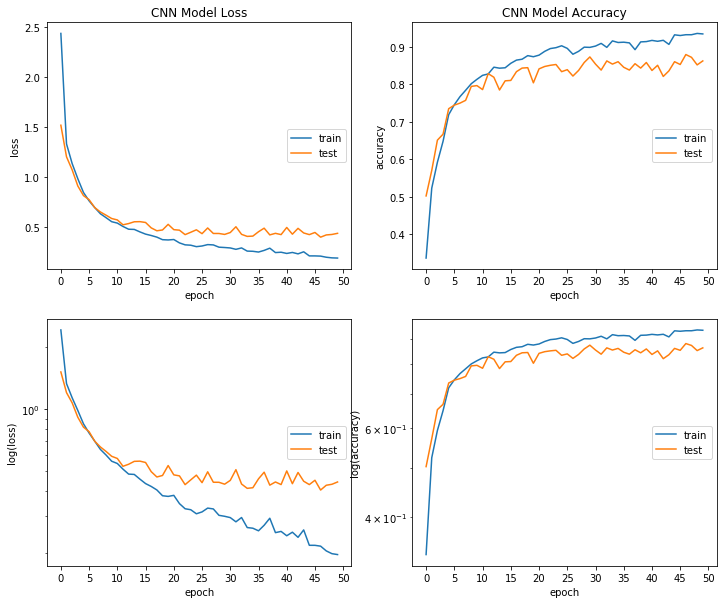

In [22]:
# summarize history of loss

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
ax1.plot(CNNmodeln.history['loss'])
ax1.plot(CNNmodeln.history['val_loss'])
ax1.set_title('CNN Model Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.locator_params(nbins=13, axis='x')
ax1.legend(['train', 'test'], loc='center right')
ax2.plot(CNNmodeln.history['accuracy'])
ax2.plot(CNNmodeln.history['val_accuracy'])
ax2.set_title('CNN Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.locator_params(nbins=12, axis='x')
ax2.legend(['train', 'test'], loc='center right')
ax3.plot(CNNmodeln.history['loss'])
ax3.plot(CNNmodeln.history['val_loss'])
ax3.set_ylabel('log(loss)')
ax3.set_xlabel('epoch')
ax3.locator_params(nbins=13, axis='x')
ax3.legend(['train', 'test'], loc='center right')
ax3.set_yscale('log')
ax4.plot(CNNmodeln.history['accuracy'])
ax4.plot(CNNmodeln.history['val_accuracy'])
ax4.set_ylabel('log(accuracy)')
ax4.set_xlabel('epoch')
ax4.locator_params(nbins=12, axis='x')
ax4.legend(['train', 'test'], loc='center right')
ax4.set_yscale('log')
plt.show
f.savefig("./plots/CNN_wo_spatial_train_north_1_north_CNN_loss_accuracy_vs_epoch.png")

In [23]:
import tensorflow as tf
from tensorflow import keras

cnnn = keras.Sequential([keras.layers.Conv1D(32, kernel_size=(5), padding="same", 
                                            activation="relu", input_shape=(cube_std_reshapedn.shape[2], 1)),
                       keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Conv1D(64, kernel_size=(5), padding="same", activation="relu"),
                        keras.layers.MaxPooling1D((2), strides=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(1024, activation="relu"),
                        keras.layers.Dense(10, activation="softmax")])

cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
           metrics=["accuracy"])

cube_trainn2 = cube_trainn.reshape(cube_trainn.shape[0], cube_trainn.shape[1], 1)
cube_testn2 = cube_testn.reshape(cube_testn.shape[0], cube_testn.shape[1], 1)

CNNmodeln = cnnn.fit(cube_trainn2, cube_train_labelsn, validation_data=(cube_testn2, cube_test_labelsn),
                     epochs=10, batch_size=512)

Train on 3764 samples, validate on 941 samples
Epoch 1/10
3764/3764 [==============================] - 3s 684us/sample - loss: 2.2170 - accuracy: 0.3326 - val_loss: 1.5595 - val_accuracy: 0.4601
Epoch 2/10
3764/3764 [==============================] - 2s 477us/sample - loss: 1.4074 - accuracy: 0.5167 - val_loss: 1.2438 - val_accuracy: 0.6174
Epoch 3/10
3764/3764 [==============================] - 2s 461us/sample - loss: 1.1677 - accuracy: 0.6214 - val_loss: 1.0598 - val_accuracy: 0.6472
Epoch 4/10
3764/3764 [==============================] - 2s 536us/sample - loss: 0.9742 - accuracy: 0.6520 - val_loss: 0.9158 - val_accuracy: 0.6642
Epoch 5/10
3764/3764 [==============================] - 2s 455us/sample - loss: 0.8519 - accuracy: 0.6987 - val_loss: 0.8165 - val_accuracy: 0.6908
Epoch 6/10
3764/3764 [==============================] - 2s 501us/sample - loss: 0.7657 - accuracy: 0.7378 - val_loss: 0.7712 - val_accuracy: 0.6833
Epoch 7/10
3764/3764 [==============================] - 2s 460us/

In [24]:
# model accuracy on training and testing sets

train_loss, train_acc = cnnn.evaluate(cube_trainn2, cube_train_labelsn)
test_loss, test_acc = cnnn.evaluate(cube_testn2, cube_test_labelsn)

print(train_acc, test_acc)

941/941 [==============================] - 0s 356us/sample - loss: 0.5465 - accuracy: 0.8119
0.84006375 0.8119022


### Predict pixel classification on north facing image

In [25]:
import time
start_time = time.time()

cube_stdn_1 = cube_standard_north.reshape(cube_standard_north.shape[0], cube_standard_north.shape[1], 1)

predictCuben = cnnn.predict_classes(cube_stdn_1)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:10:13


In [26]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

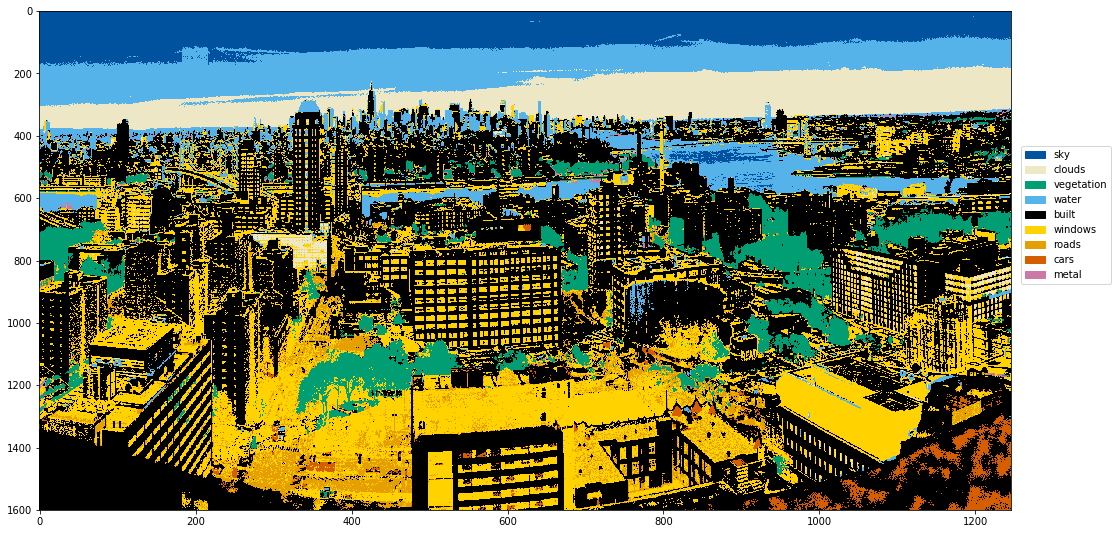

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
fig.savefig("./plots/CNN_wo_spatial_train_north_2_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [28]:
veg_by_row_north = np.zeros(cube_sub_north.shape[1])
for row in range(0, cube_sub_north.shape[1]):
    veg_by_row_north[row] = np.count_nonzero(predictCube_reshapen[row,:] == 2)

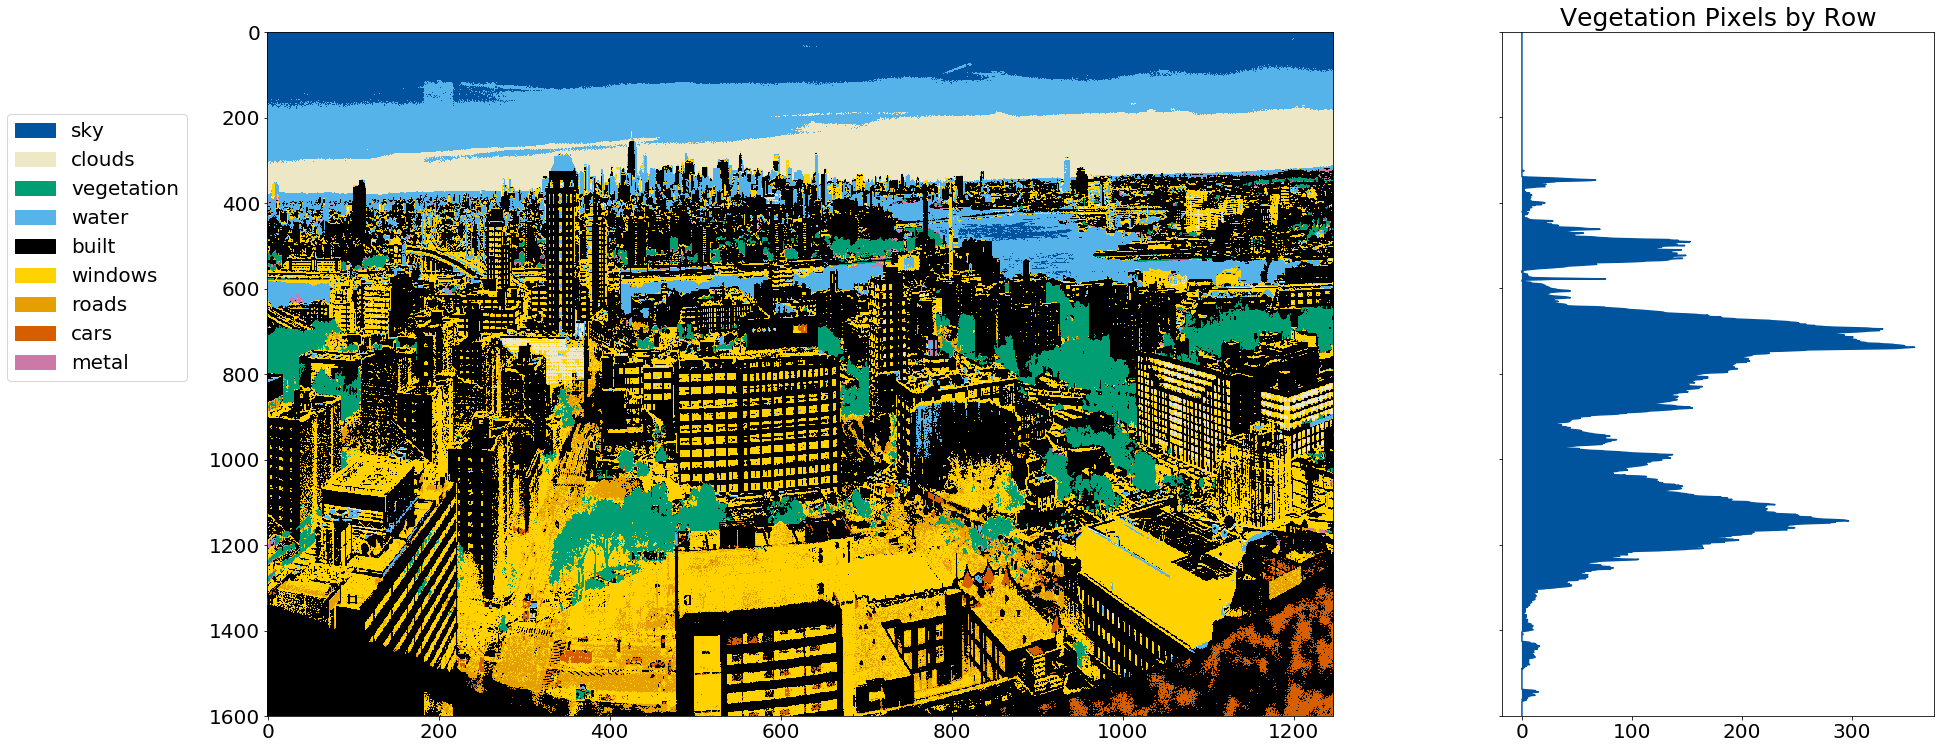

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row_north, np.arange(0,cube_sub_north.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row_north, np.arange(0,cube_sub_north.shape[1]), cube_sub_north.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub_north.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

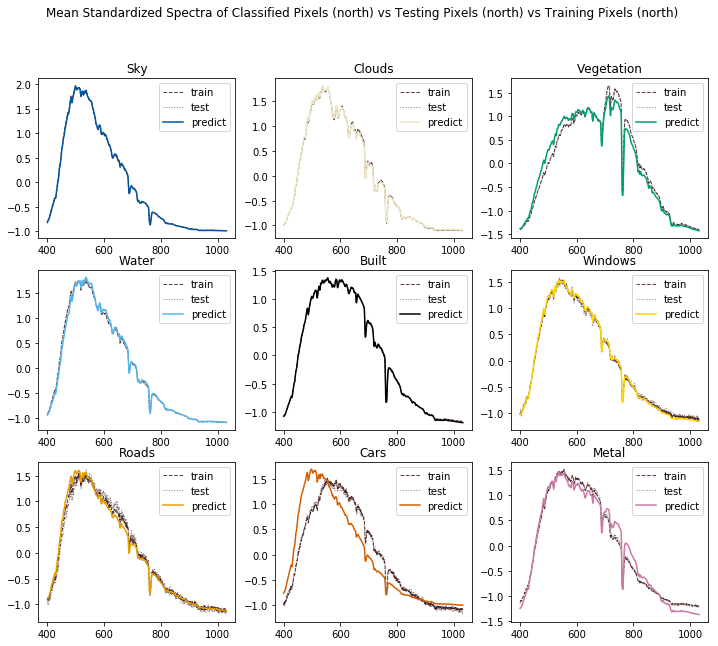

In [30]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (north) vs Testing Pixels (north) vs Training Pixels (north)')
ax1.plot(cube_north.waves, cube_sky_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube_north.waves, cube_sky_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube_north.waves, cube_clouds_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube_north.waves, cube_clouds_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube_north.waves, cube_veg_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube_north.waves, cube_veg_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube_north.waves, cube_wtr_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube_north.waves, cube_wtr_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube_north.waves, cube_blt_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube_north.waves, cube_blt_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube_north.waves, cube_windows_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube_north.waves, cube_windows_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube_north.waves, cube_rds_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube_north.waves, cube_rds_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube_north.waves, cube_cars_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube_north.waves, cube_cars_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube_north.waves, cube_mtl_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube_north.waves, cube_mtl_testn.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube_north.waves, cube_reshaped_north[np.where(predictCuben == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
f.savefig("./plots/CNN_wo_spatial_train_north_3_north_mean_spectra_train_test_predict_3x3.png")

### Evaluation Metrics (north facing)

In [31]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[:,0], sky_coordsn[:,1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[:,0], clouds_coordsn[:,1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[:,0], veg_coordsn[:,1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[:,0], wtr_coordsn[:,1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[:,0], blt_coordsn[:,1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[:,0], windows_coordsn[:,1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[:,0], rds_coordsn[:,1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[:,0], cars_coordsn[:,1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[:,0], mtl_coordsn[:,1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [32]:
labelsn_true_sky = np.full((sky_coordsn.shape[0]), 0)
labelsn_true_clouds = np.full((clouds_coordsn.shape[0]), 1)
labelsn_true_veg = np.full((veg_coordsn.shape[0]), 2)
labelsn_true_wtr = np.full((wtr_coordsn.shape[0]), 3)
labelsn_true_blt = np.full((blt_coordsn.shape[0]), 4)
labelsn_true_windows = np.full((windows_coordsn.shape[0]), 5)
labelsn_true_rds = np.full((rds_coordsn.shape[0]), 6)
labelsn_true_cars = np.full((cars_coordsn.shape[0]), 7)
labelsn_true_mtl = np.full((mtl_coordsn.shape[0]), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [33]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

(4705,)
(4705,)


In [35]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

Confusion Matrix
[[ 294    0    0    6    0    0    0    0    0]
 [   0  199    0    1    0    0    0    0    0]
 [   0    0  697    0    3    0    0    0    0]
 [  64    0    0  517    9   23    0    0    7]
 [   0    0    0   16 1462  105    1   16    0]
 [   0    6    5    7   74  495   10    1    2]
 [   0    0    2    3   40   58  147    0    0]
 [   0    2    0   11   89   31    1  115    1]
 [   0    0    0   33   87   65    0    0    0]]

Accuracy Score
0.8344314558979808

Classification Report
             precision    recall  f1-score   support

        sky       0.82      0.98      0.89       300
     clouds       0.96      0.99      0.98       200
 vegetation       0.99      1.00      0.99       700
      water       0.87      0.83      0.85       620
      built       0.83      0.91      0.87      1600
    windows       0.64      0.82      0.72       600
      roads       0.92      0.59      0.72       250
       cars       0.87      0.46      0.60       250
      metal   

In [36]:
f = open("./metrics/CNN_wo_spatial_train_north_test_north_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()

In [37]:
sky_dictn, sky_dict_normn = kmeans_test_dictionary(predictCube_reshapen, sky_coordsn, 9)
clouds_dictn, cloud_dict_normn = kmeans_test_dictionary(predictCube_reshapen, clouds_coordsn, 9)
veg_dictn, veg_dict_normn = kmeans_test_dictionary(predictCube_reshapen, veg_coordsn, 9)
wtr_dictn, wtr_dict_normn = kmeans_test_dictionary(predictCube_reshapen, wtr_coordsn, 9)
blt_dictn, blt_dict_normn = kmeans_test_dictionary(predictCube_reshapen, blt_coordsn, 9)
windows_dictn, windows_dict_normn = kmeans_test_dictionary(predictCube_reshapen, windows_coordsn, 9)
rds_dictn, rds_dict_normn = kmeans_test_dictionary(predictCube_reshapen, rds_coordsn, 9)
cars_dictn, cars_dict_normn = kmeans_test_dictionary(predictCube_reshapen, cars_coordsn, 9)
mtl_dictn, mtl_dict_normn = kmeans_test_dictionary(predictCube_reshapen, mtl_coordsn, 9)

df_testn = kmeans_test_dataframe(sky_dictn, clouds_dictn, veg_dictn, wtr_dictn,
                                blt_dictn, windows_dictn, rds_dictn, cars_dictn, mtl_dictn)
print(df_testn.transpose())
df_test_normn = kmeans_test_dataframe(sky_dictn, clouds_dictn, veg_dictn, wtr_dictn,
                                     blt_dictn, windows_dictn, rds_dictn, cars_dictn, mtl_dictn)
#print("")
#print(df_test_normn.transpose())

              0    1    2    3     4    5    6    7  8
sky         294    0    0    6     0    0    0    0  0
clouds        0  199    0    1     0    0    0    0  0
vegetation    0    0  697    0     3    0    0    0  0
water        64    0    0  517     9   23    0    0  7
built         0    0    0   16  1462  105    1   16  0
windows       0    6    5    7    74  495   10    1  2
roads         0    0    2    3    40   58  147    0  0
cars          0    2    0   11    89   31    1  115  1
metal         0    0    0   33    87   65    0    0  0


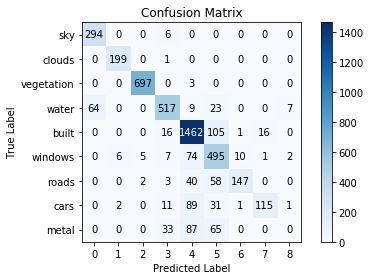

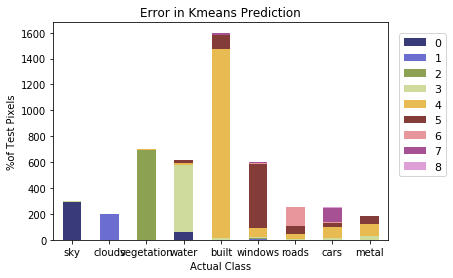

In [38]:
plot_confusion_matrix(df_testn, norm=False)
#plot_confusion_matrix(df_test_normn, norm=True)
plot_test_result(df_test_normn)

#### CNN Features

In [39]:
#summarize filter shapes

for layer in cnnn.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv1d_2 (5, 1, 32)
conv1d_3 (5, 32, 64)


In [40]:
filters, biases = cnnn.layers[0].get_weights()
print(filters.shape)

(5, 1, 32)


In [41]:
cnnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 872, 32)           192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 436, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 436, 64)           10304     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 218, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13952)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              14287872  
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [42]:
c0 = cube_standard_north[np.where(predictCuben == 0)[0]].mean(0)
c1 = cube_standard_north[np.where(predictCuben == 1)[0]].mean(0)
c2 = cube_standard_north[np.where(predictCuben == 2)[0]].mean(0)
c3 = cube_standard_north[np.where(predictCuben == 3)[0]].mean(0)
c4 = cube_standard_north[np.where(predictCuben == 4)[0]].mean(0)
c5 = cube_standard_north[np.where(predictCuben == 5)[0]].mean(0)
c6 = cube_standard_north[np.where(predictCuben == 6)[0]].mean(0)
c7 = cube_standard_north[np.where(predictCuben == 7)[0]].mean(0)
c8 = cube_standard_north[np.where(predictCuben == 8)[0]].mean(0)

In [43]:
cr0 = c0.reshape(1, c0.shape[0], 1)
cr1 = c1.reshape(1, c1.shape[0], 1)
cr2 = c2.reshape(1, c2.shape[0], 1)
cr3 = c3.reshape(1, c3.shape[0], 1)
cr4 = c4.reshape(1, c4.shape[0], 1)
cr5 = c5.reshape(1, c5.shape[0], 1)
cr6 = c6.reshape(1, c6.shape[0], 1)
cr7 = c7.reshape(1, c7.shape[0], 1)
cr8 = c8.reshape(1, c8.shape[0], 1)

In [44]:
print('sky', cnnn.predict_classes(cr0))
print('clouds', cnnn.predict_classes(cr1))
print('veg', cnnn.predict_classes(cr2))
print('water', cnnn.predict_classes(cr3))
print('built', cnnn.predict_classes(cr4))
print('windows', cnnn.predict_classes(cr5))
print('roads', cnnn.predict_classes(cr6))
print('cars', cnnn.predict_classes(cr7))
print('metal', cnnn.predict_classes(cr8))

sky [0]
clouds [1]
veg [2]
water [3]
built [4]
windows [3]
roads [3]
cars [0]
metal [3]


In [45]:
outputs = [cnnn.layers[0].output]
submodel = keras.Model(inputs=cnnn.inputs, outputs=outputs)

In [46]:
featuremap0 = submodel.predict(cr0)
featuremap1 = submodel.predict(cr1)
featuremap2 = submodel.predict(cr2)
featuremap3 = submodel.predict(cr3)
featuremap4 = submodel.predict(cr4)
featuremap5 = submodel.predict(cr5)
featuremap6 = submodel.predict(cr6)
featuremap7 = submodel.predict(cr7)
featuremap8 = submodel.predict(cr8)

In [47]:
featuremap = np.concatenate((featuremap0, featuremap1, featuremap2, featuremap3, featuremap4,
                            featuremap5, featuremap6, featuremap7, featuremap8), axis=0)
print(featuremap.shape)

(9, 872, 32)


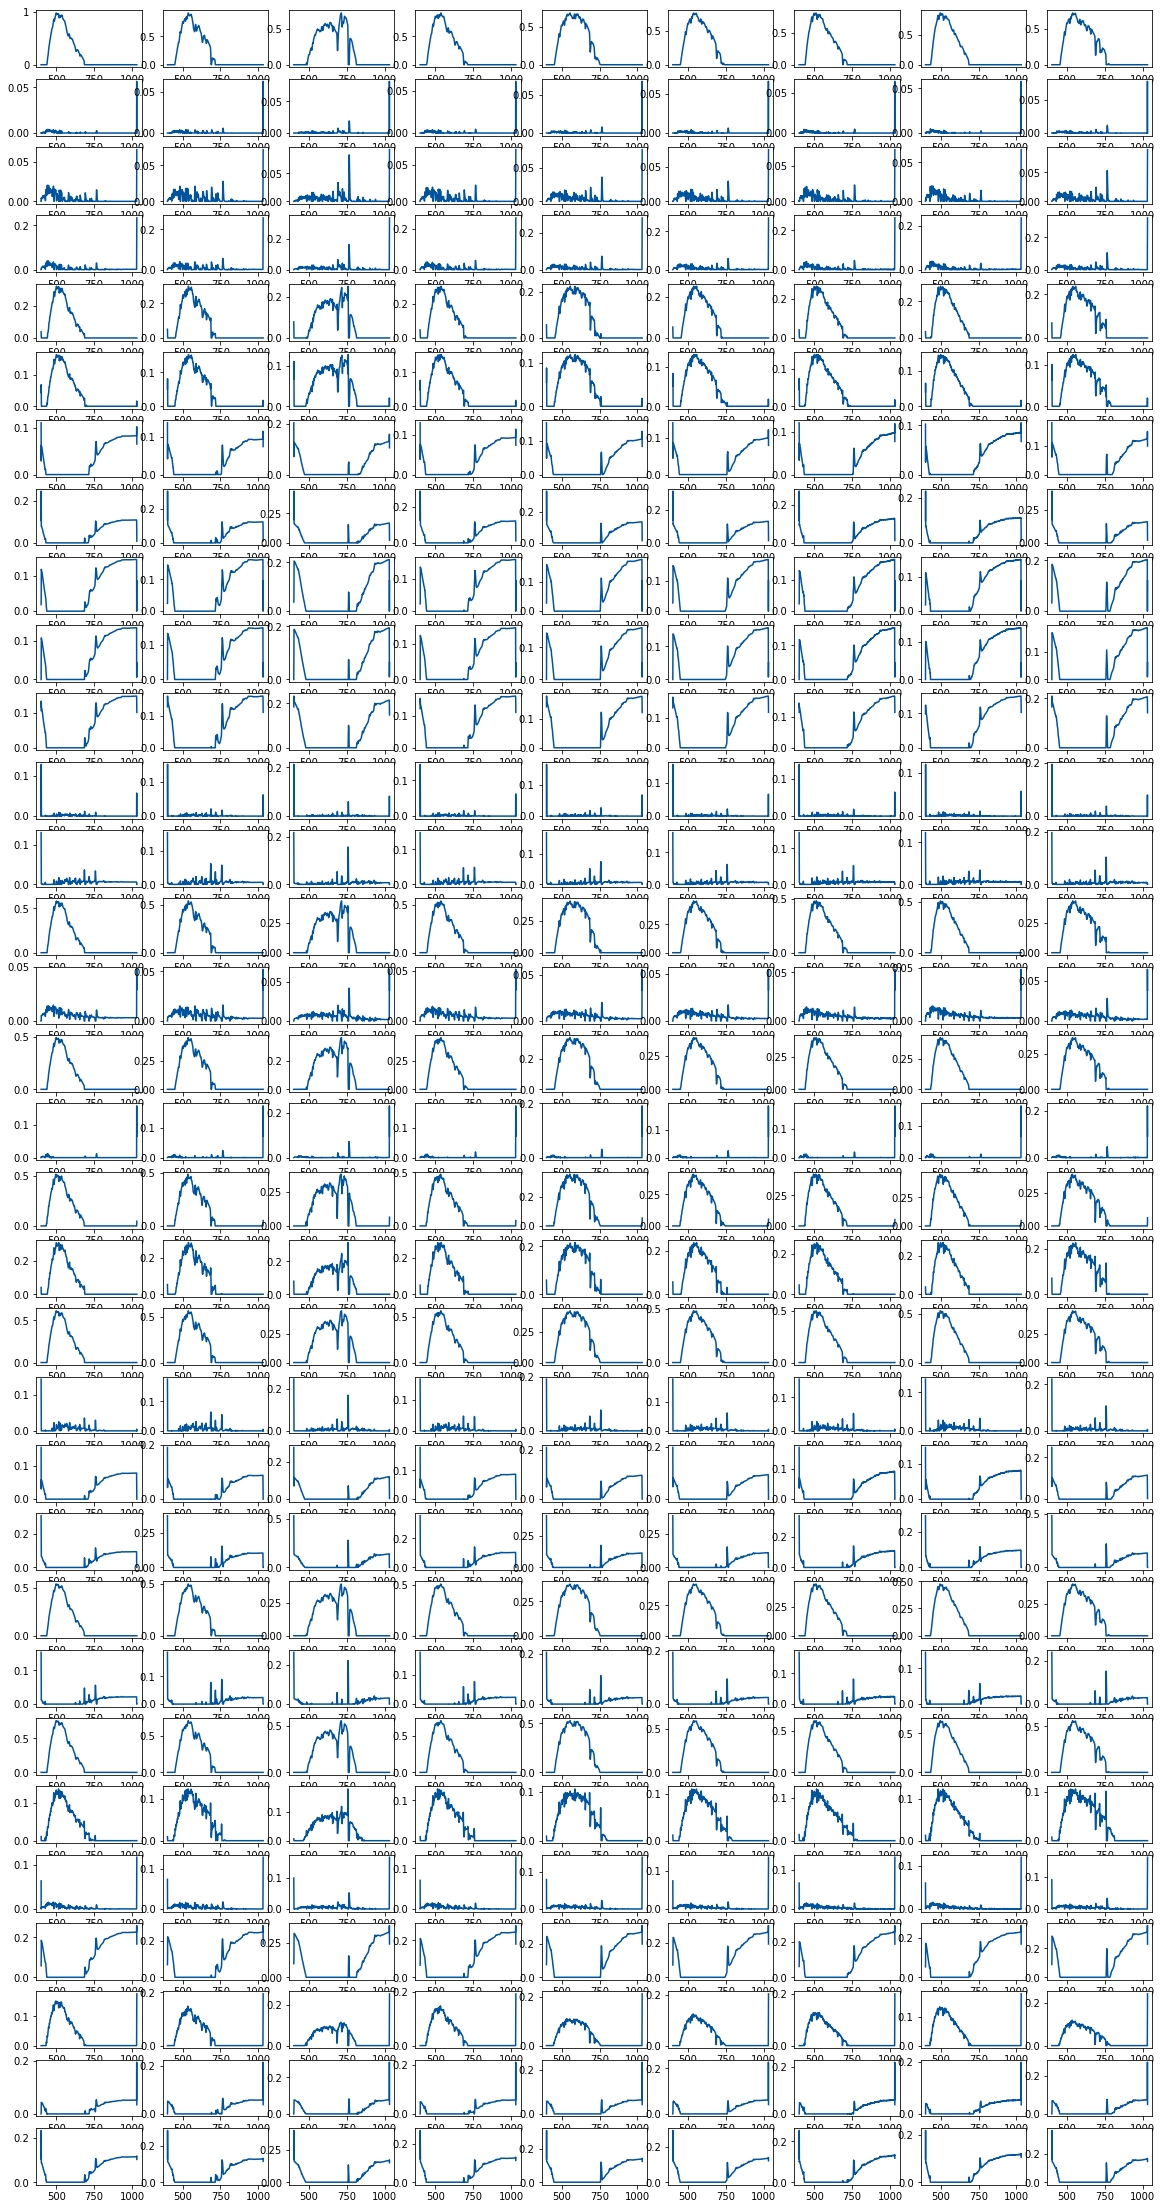

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

xdatan = cube_north.waves
#xdatan = np.append(xdatan, [1010,1015])

f, axs = plt.subplots(32, 9, figsize=(20,40))
for i in range(32):
    for j in range(9):
        axs[i,j].plot(xdatan, featuremap[j,:,i], color=[0.0,0.33,0.62])

plt.show()
f.savefig("./plots/CNN_wo_spatial_train_north_4_north_CNN_feature_map_32x9.png")

---
## CNN tested on veg_00108 (South Facing @ ~2pm)

In [51]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [52]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [53]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


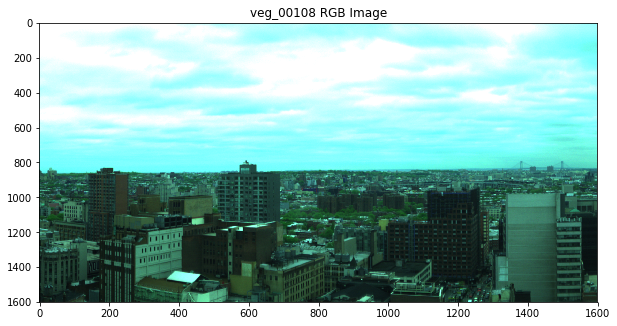

In [54]:
cube_norm = (cube_reshaped - cube_reshaped.min()) / (cube_reshaped.max() - cube_reshaped.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind = (np.abs(cube.waves - 650.0)).argmin()
green_ind = (np.abs(cube.waves - 550.0)).argmin()
blue_ind = (np.abs(cube.waves - 450.0)).argmin()

cube_reshaped2 = cube_norm.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub.shape[0])
cube_scene = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 RGB Image')
ax.imshow(cube_scene, aspect=0.5)
plt.show()

W0303 18:13:10.694689 140694560790016 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


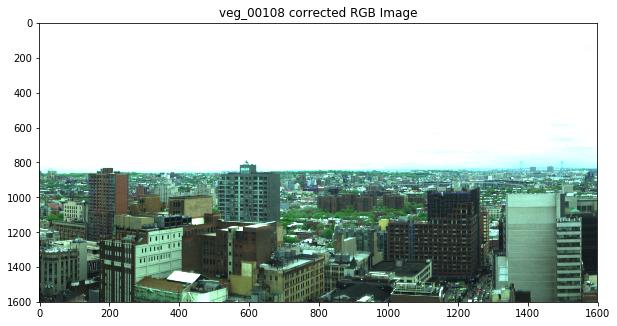

In [55]:
rgb = cube_reshaped2[:, :, [red_ind, green_ind, blue_ind]].copy()
rgb /= rgb.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00108 corrected RGB Image')
ax.imshow(rgb, aspect=0.5)
plt.show()

In [56]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
cube_reshaped = cube_standard

In [57]:
print(len(cube_north.waves))
print(min(cube_north.waves), max(cube_north.waves))
print()
print(len(cube.waves))
print(min(cube.waves), max(cube.waves))

872
400.46 1031.29

848
395.46 1008.06


In [58]:
# interpolating an extrapolating the north facing scene

from scipy.interpolate import interp1d

interp_hsi = interp1d(cube.waves, cube_reshaped, axis=1, fill_value="extrapolate")
cube_ri = interp_hsi(cube_north.waves)

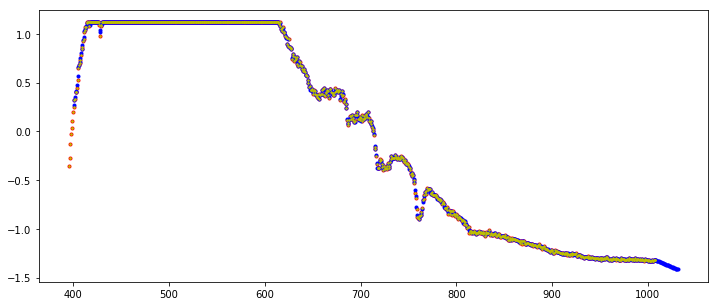

In [59]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cube.waves, cube_reshaped[1000, :], ".", color="r")
ax.plot(cube_north.waves, cube_ri[1000, :], 'o', ms=3, color="b")
ax.plot(cube.waves, cube_reshaped[1000, :], ".", ms=3, color="y")

In [60]:
print(cube_reshaped.shape)
print(cube_ri.shape)

(2560000, 848)
(2560000, 872)


In [62]:
import time
start_time = time.time()

cube_std_1 = cube_ri.reshape(cube_ri.shape[0], cube_ri.shape[1], 1)

predictCube = cnnn.predict_classes(cube_std_1)
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:13:37


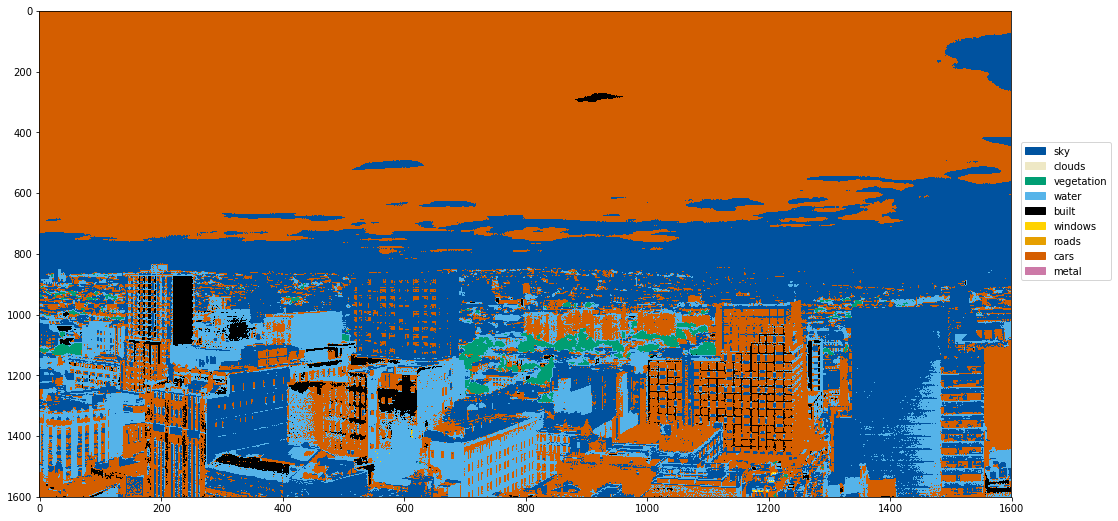

In [63]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
fig.savefig("./plots/CNN_wo_spatial_train_north_5_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [64]:
veg_by_row = np.zeros(cube_sub.shape[1])
for row in range(0, cube_sub.shape[1]):
    veg_by_row[row] = np.count_nonzero(predictCube_reshape[row,:] == 2)

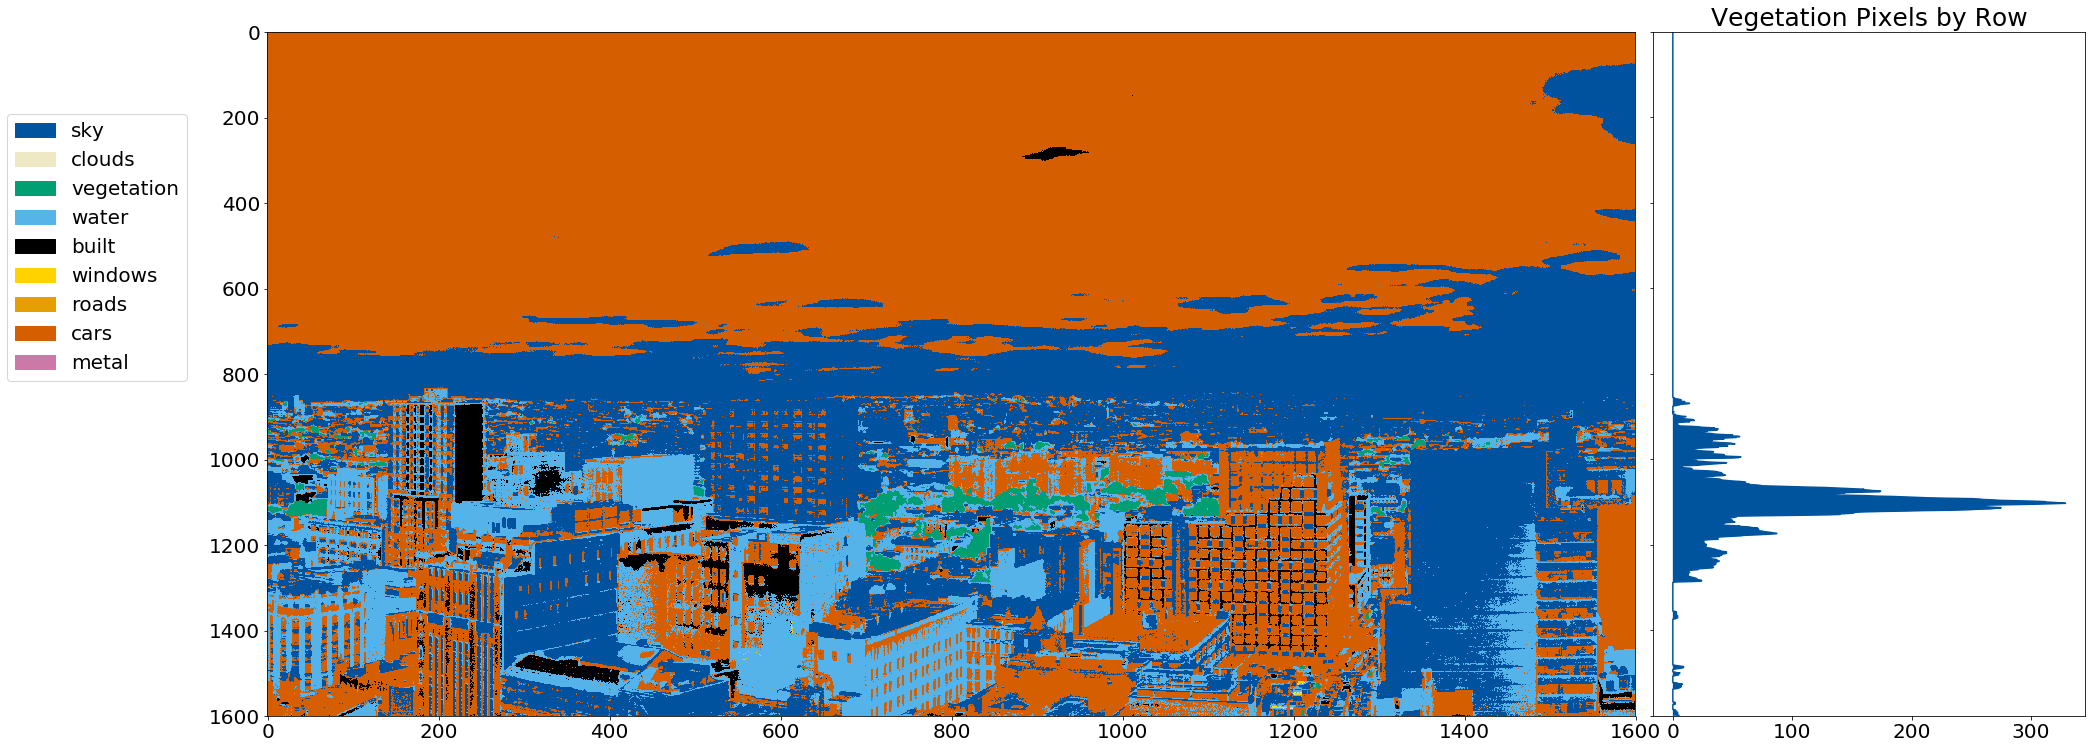

In [67]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row, np.arange(0,cube_sub.shape[1]), cube_sub.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

### read test sample (veg_00108)

In [68]:
# read manually selected coordinates files

#sky coordinates
sky_file = open("../manual_classified_pixels/1_sky_coordinates_108.txt", "r")
sky_coords = sky_file.readlines()
sky_file.close()
sky_coords = np.array([point_from_string(line) for line in sky_coords])
print("sky:        ", sky_coords.shape)

#clouds coordinates
clouds_file = open("../manual_classified_pixels/2_clouds_coordinates_108.txt", "r")
clouds_coords = clouds_file.readlines()
clouds_file.close()
clouds_coords = np.array([point_from_string(line) for line in clouds_coords])
print("clouds:     ", clouds_coords.shape)

#vegetation coordinates
veg_file = open("../manual_classified_pixels/3_vegetation_coordinates_108.txt", "r")
veg_coords = veg_file.readlines()
veg_file.close()
veg_coords = np.array([point_from_string(line) for line in veg_coords])
print("vegetation: ", veg_coords.shape)

#water coordinates
wtr_file = open("../manual_classified_pixels/4_water_coordinates_108.txt", "r")
wtr_coords = wtr_file.readlines()
wtr_file.close()
wtr_coords = np.array([point_from_string(line) for line in wtr_coords])
print("water:      ", wtr_coords.shape)

#buildings coordinates
blt_file = open("../manual_classified_pixels/5_buildings_coordinates_108.txt", "r")
blt_coords = blt_file.readlines()
blt_file.close()
blt_coords = np.array([point_from_string(line) for line in blt_coords])
print("buildings:  ", blt_coords.shape)

#windows coordinates
windows_file = open("../manual_classified_pixels/6_windows_coordinates_108.txt", "r")
windows_coords = windows_file.readlines()
windows_file.close()
windows_coords = np.array([point_from_string(line) for line in windows_coords])
print("windows:    ", windows_coords.shape)

#roads coordinates
rds_file = open("../manual_classified_pixels/7_roads_coordinates_108.txt", "r")
rds_coords = rds_file.readlines()
rds_file.close()
rds_coords = np.array([point_from_string(line) for line in rds_coords])
print("road:       ", rds_coords.shape)

#cars coordinates
cars_file = open("../manual_classified_pixels/8_cars_coordinates_108.txt", "r")
cars_coords = cars_file.readlines()
cars_file.close()
cars_coords = np.array([point_from_string(line) for line in cars_coords])
print("cars:       ", cars_coords.shape)

#metal coordinates
mtl_file = open("../manual_classified_pixels/9_metal_coordinates_108.txt", "r")
mtl_coords = mtl_file.readlines()
mtl_file.close()
mtl_coords = np.array([point_from_string(line) for line in mtl_coords])
print("metal:      ", mtl_coords.shape)

sky:         (300, 2)
clouds:      (500, 2)
vegetation:  (600, 2)
water:       (50, 2)
buildings:   (1020, 2)
windows:     (500, 2)
road:        (30, 2)
cars:        (100, 2)
metal:       (100, 2)


In [69]:
labels_pred_sky = predictCube_reshape[sky_coords[:,0], sky_coords[:,1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[:,0], clouds_coords[:,1]]
labels_pred_veg = predictCube_reshape[veg_coords[:,0], veg_coords[:,1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[:,0], wtr_coords[:,1]]
labels_pred_blt = predictCube_reshape[blt_coords[:,0], blt_coords[:,1]]
labels_pred_windows = predictCube_reshape[windows_coords[:,0], windows_coords[:,1]]
labels_pred_rds = predictCube_reshape[rds_coords[:,0], rds_coords[:,1]]
labels_pred_cars = predictCube_reshape[cars_coords[:,0], cars_coords[:,1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[:,0], mtl_coords[:,1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [70]:
labels_true_sky = np.full((sky_coords.shape[0]), 0)
labels_true_clouds = np.full((clouds_coords.shape[0]), 1)
labels_true_veg = np.full((veg_coords.shape[0]), 2)
labels_true_wtr = np.full((wtr_coords.shape[0]), 3)
labels_true_blt = np.full((blt_coords.shape[0]), 4)
labels_true_windows = np.full((windows_coords.shape[0]), 5)
labels_true_rds = np.full((rds_coords.shape[0]), 6)
labels_true_cars = np.full((cars_coords.shape[0]), 7)
labels_true_mtl = np.full((mtl_coords.shape[0]), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [71]:
print(labels_pred.shape)
print(labels_true.shape)

(3200,)
(3200,)


In [72]:
cube_std_reshape = cube_ri.reshape(cube_sub.shape[1], cube_sub.shape[2], cube_sub_north.shape[0])

In [73]:
sky_ind = np.arange(sky_coords.shape[0])
cube_sky_test = cube_std_reshape[sky_coords[sky_ind[:], 0], sky_coords[sky_ind[:], 1], :]
clouds_ind = np.arange(clouds_coords.shape[0])
cube_clouds_test = cube_std_reshape[clouds_coords[clouds_ind[:], 0], clouds_coords[clouds_ind[:], 1], :]
veg_ind = np.arange(veg_coords.shape[0])
cube_veg_test = cube_std_reshape[veg_coords[veg_ind[:], 0], veg_coords[veg_ind[:], 1], :]
wtr_ind = np.arange(wtr_coords.shape[0])
cube_wtr_test = cube_std_reshape[wtr_coords[wtr_ind[:], 0], wtr_coords[wtr_ind[:], 1], :]
blt_ind = np.arange(blt_coords.shape[0])
cube_blt_test = cube_std_reshape[blt_coords[blt_ind[:], 0], blt_coords[blt_ind[:], 1], :]
windows_ind = np.arange(windows_coords.shape[0])
cube_windows_test = cube_std_reshape[windows_coords[windows_ind[:], 0], windows_coords[windows_ind[:], 1], :]
rds_ind = np.arange(rds_coords.shape[0])
cube_rds_test = cube_std_reshape[rds_coords[rds_ind[:], 0], rds_coords[rds_ind[:], 1], :]
cars_ind = np.arange(cars_coords.shape[0])
cube_cars_test = cube_std_reshape[cars_coords[cars_ind[:], 0], cars_coords[cars_ind[:], 1], :]
mtl_ind = np.arange(mtl_coords.shape[0])
cube_mtl_test = cube_std_reshape[mtl_coords[mtl_ind[:], 0], mtl_coords[mtl_ind[:], 1], :]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.


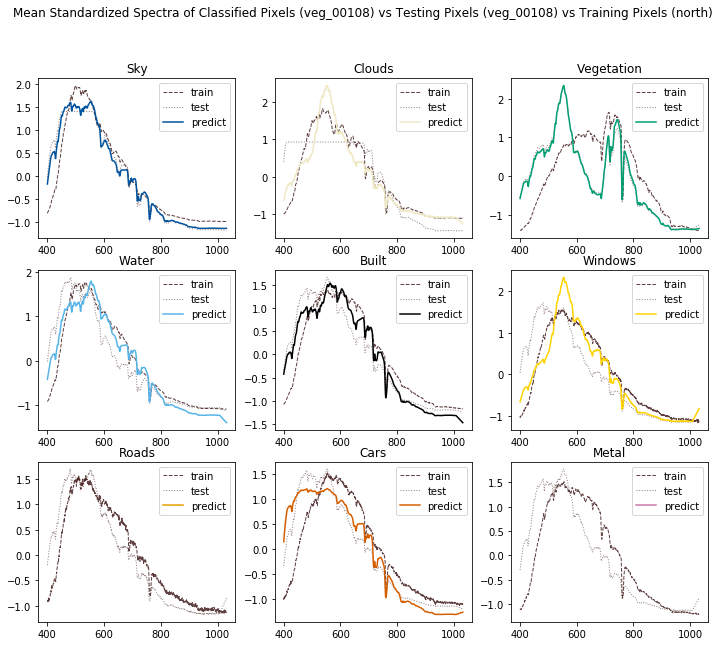

In [94]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00108) vs Testing Pixels (veg_00108) vs Training Pixels (north)')
ax1.plot(cube_north.waves, cube_sky_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube_north.waves, cube_sky_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube_north.waves, cube_ri[np.where(predictCube == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube_north.waves, cube_clouds_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube_north.waves, cube_clouds_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube_north.waves, cube_ri[np.where(predictCube == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube_north.waves, cube_veg_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube_north.waves, cube_veg_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube_north.waves, cube_ri[np.where(predictCube == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube_north.waves, cube_wtr_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube_north.waves, cube_wtr_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube_north.waves, cube_ri[np.where(predictCube == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube_north.waves, cube_blt_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube_north.waves, cube_blt_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube_north.waves, cube_ri[np.where(predictCube == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube_north.waves, cube_windows_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube_north.waves, cube_windows_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube_north.waves, cube_ri[np.where(predictCube == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube_north.waves, cube_rds_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube_north.waves, cube_rds_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube_north.waves, cube_ri[np.where(predictCube == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube_north.waves, cube_cars_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube_north.waves, cube_cars_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube_north.waves, cube_ri[np.where(predictCube == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube_north.waves, cube_mtl_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube_north.waves, cube_mtl_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube_north.waves, cube_ri[np.where(predictCube == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
f.savefig("./plots/CNN_wo_spatial_train_north_6_108_mean_spectra_train_test_predict_3x3.png")

### Evaluation Metrics (veg_00108)

In [75]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[230   0   0   0   0   0   0  70   0]
 [  0   0   0   0   5   0   0 495   0]
 [ 34   0 418 117   0   0   0  31   0]
 [ 50   0   0   0   0   0   0   0   0]
 [443   0   0 276 176   0   0 125   0]
 [ 32   0   0   5   0   0   0 463   0]
 [ 12   0   0   2   0   0   0  16   0]
 [ 68   0   0  17   5   0   0  10   0]
 [ 50   0   0  24   0   0   0  26   0]]

Accuracy Score
0.260625

Classification Report
             precision    recall  f1-score   support

        sky       0.25      0.77      0.38       300
     clouds       0.00      0.00      0.00       500
 vegetation       1.00      0.70      0.82       600
      water       0.00      0.00      0.00        50
      built       0.95      0.17      0.29      1020
    windows       0.00      0.00      0.00       500
      roads       0.00      0.00      0.00        30
       cars       0.01      0.10      0.01       100
      metal       0.00      0.00      0.00       100

avg / total       0.51      0.26      0.28      320

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
f = open("./metrics/CNN_wo_spatial_train_north_test_108_binned_848_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
sky_dict, sky_dict_norm = kmeans_test_dictionary(predictCube_reshape, sky_coords, 9)
clouds_dict, cloud_dict_norm = kmeans_test_dictionary(predictCube_reshape, clouds_coords, 9)
veg_dict, veg_dict_norm = kmeans_test_dictionary(predictCube_reshape, veg_coords, 9)
wtr_dict, wtr_dict_norm = kmeans_test_dictionary(predictCube_reshape, wtr_coords, 9)
blt_dict, blt_dict_norm = kmeans_test_dictionary(predictCube_reshape, blt_coords, 9)
windows_dict, windows_dict_norm = kmeans_test_dictionary(predictCube_reshape, windows_coords, 9)
rds_dict, rds_dict_norm = kmeans_test_dictionary(predictCube_reshape, rds_coords, 9)
cars_dict, cars_dict_norm = kmeans_test_dictionary(predictCube_reshape, cars_coords, 9)
mtl_dict, mtl_dict_norm = kmeans_test_dictionary(predictCube_reshape, mtl_coords, 9)

df_test = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
print(df_test.transpose())
df_test_norm = kmeans_test_dataframe(sky_dict, clouds_dict, veg_dict, wtr_dict,
                                     blt_dict, windows_dict, rds_dict, cars_dict, mtl_dict)
#print("")
#print(df_test_norm.transpose())

              0  1    2    3    4  5  6    7  8
sky         230  0    0    0    0  0  0   70  0
clouds        0  0    0    0    5  0  0  495  0
vegetation   34  0  418  117    0  0  0   31  0
water        50  0    0    0    0  0  0    0  0
built       443  0    0  276  176  0  0  125  0
windows      32  0    0    5    0  0  0  463  0
roads        12  0    0    2    0  0  0   16  0
cars         68  0    0   17    5  0  0   10  0
metal        50  0    0   24    0  0  0   26  0


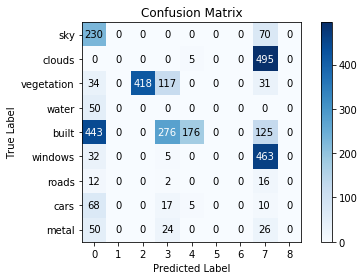

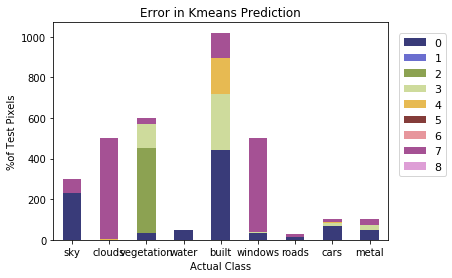

In [79]:
plot_confusion_matrix(df_test, norm=False)
#plot_confusion_matrix(df_test_norm, norm=True)
plot_test_result(df_test_norm)

---
## CNN tested on veg_00000 (South Facing @ ~6pm)

In [81]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [84]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [85]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


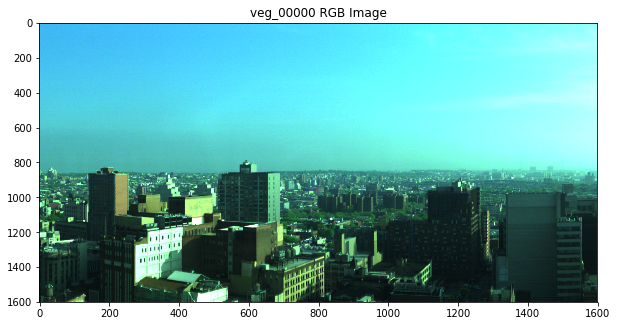

In [86]:
cube_norm0 = (cube_reshaped0 - cube_reshaped0.min()) / (cube_reshaped0.max() - cube_reshaped0.min())

import matplotlib.pyplot as plt
%matplotlib inline

red_ind0 = (np.abs(cube0.waves - 650.0)).argmin()
green_ind0 = (np.abs(cube0.waves - 550.0)).argmin()
blue_ind0 = (np.abs(cube0.waves - 450.0)).argmin()

cube_reshaped02 = cube_norm0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub0.shape[0])
cube_scene0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 RGB Image')
ax.imshow(cube_scene0, aspect=0.5)
plt.show()

W0303 18:50:37.971563 140694560790016 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


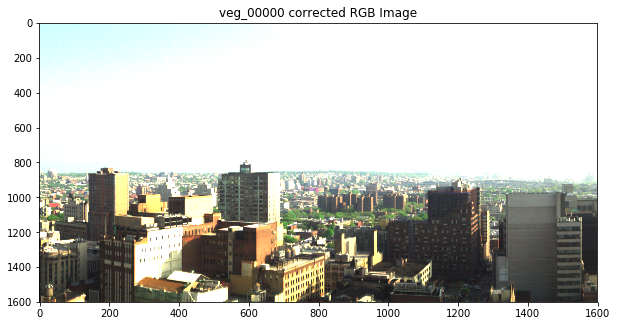

In [87]:
rgb0 = cube_reshaped02[:, :, [red_ind0, green_ind0, blue_ind0]].copy()
rgb0 /= rgb0.mean((0, 1), keepdims=True)

fig, ax = plt.subplots(figsize=(10,10))
plt.title('veg_00000 corrected RGB Image')
ax.imshow(rgb0, aspect=0.5)
plt.show()

In [89]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)
cube_reshaped0 = cube_standard0

In [95]:
print(len(cube_north.waves))
print(min(cube_north.waves), max(cube_north.waves))
print()
print(len(cube0.waves))
print(min(cube0.waves), max(cube0.waves))

872
400.46 1031.29

848
395.46 1008.06


In [ ]:
# interpolating an extrapolating the north facing scene

from scipy.interpolate import interp1d

interp_hsi = interp1d(cube0.waves, cube_reshaped0, axis=1, fill_value="extrapolate")
cube_ri0 = interp_hsi(cube_north.waves)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cube0.waves, cube_reshaped0[1000, :], ".", color="r")
ax.plot(cube_north.waves, cube_ri0[1000, :], 'o', ms=3, color="b")
ax.plot(cube0.waves, cube_reshaped0[1000, :], ".", ms=3, color="y")

In [ ]:
print(cube_reshaped0.shape)
print(cube_ri0.shape)

In [ ]:
import time
start_time = time.time()

cube_std0_1 = cube_ri0.reshape(cube_ri0.shape[0], cube_ri0.shape[1], 1)

predictCube0 = cnn.predict_classes(cube_std0_1)
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
fig.savefig("./plots/CNN_wo_spatial_train_north_7_000_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
veg_by_row0 = np.zeros(cube_sub0.shape[1])
for row in range(0, cube_sub0.shape[1]):
    veg_by_row0[row] = np.count_nonzero(predictCube_reshape0[row,:] == 2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
#fig, ax = plt.subplots(figsize = (20,10))

fig = plt.figure(1, figsize=(30,10))
axImage = plt.axes([0.1,0.1,0.85,0.95])
axHist = plt.axes([0.85,0.1,0.2,0.95])
axHist.yaxis.set_major_formatter(NullFormatter())
axImage.tick_params(labelsize=20)
axHist.tick_params(labelsize=20)
axImage.imshow(arrayShow, aspect=0.5)
axHist.plot(veg_by_row0, np.arange(0,cube_sub.shape[1]), color=[0.0,0.33,0.62])
axHist.fill_between(veg_by_row0, np.arange(0,cube_sub0.shape[1]), cube_sub0.shape[1], facecolor=[0.0,0.33,0.62])
axHist.set_ylim(cube_sub0.shape[1], 0)
axHist.set(title='Vegetation Pixels by Row')
axHist.title.set_fontsize(25)
lgd = axImage.legend(handles=patches, bbox_to_anchor=(0,0.5), loc=2, borderaxespad=-13.0, prop={'size':20}, ncol=1)
plt.show()
#fig.savefig("./output/plots/19_kmeans_clustering_of_veg_00108.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

### read test sample (veg_00000)

In [ ]:
# read manually selected coordinates files

#sky coordinates
sky_file0 = open("../manual_classified_pixels/1_sky_coordinates_000.txt", "r")
sky_coords0 = sky_file0.readlines()
sky_file0.close()
sky_coords0 = np.array([point_from_string(line) for line in sky_coords0])
print("sky:        ", sky_coords0.shape)

#clouds coordinates
clouds_file0 = open("../manual_classified_pixels/2_clouds_coordinates_000.txt", "r")
clouds_coords0 = clouds_file0.readlines()
clouds_file0.close()
clouds_coords0 = np.array([point_from_string(line) for line in clouds_coords0])
print("clouds:     ", clouds_coords0.shape)

#vegetation coordinates
veg_file0 = open("../manual_classified_pixels/3_vegetation_coordinates_000.txt", "r")
veg_coords0 = veg_file0.readlines()
veg_file0.close()
veg_coords0 = np.array([point_from_string(line) for line in veg_coords0])
print("vegetation: ", veg_coords0.shape)

#water coordinates
wtr_file0 = open("../manual_classified_pixels/4_water_coordinates_000.txt", "r")
wtr_coords0 = wtr_file0.readlines()
wtr_file0.close()
wtr_coords0 = np.array([point_from_string(line) for line in wtr_coords0])
print("water:      ", wtr_coords0.shape)

#buildings coordinates
blt_file0 = open("../manual_classified_pixels/5_buildings_coordinates_000.txt", "r")
blt_coords0 = blt_file0.readlines()
blt_file0.close()
blt_coords0 = np.array([point_from_string(line) for line in blt_coords0])
print("buildings:  ", blt_coords0.shape)

#windows coordinates
windows_file0 = open("../manual_classified_pixels/6_windows_coordinates_000.txt", "r")
windows_coords0 = windows_file0.readlines()
windows_file0.close()
windows_coords0 = np.array([point_from_string(line) for line in windows_coords0])
print("windows:    ", windows_coords0.shape)

#roads coordinates
rds_file0 = open("../manual_classified_pixels/7_roads_coordinates_000.txt", "r")
rds_coords0 = rds_file0.readlines()
rds_file0.close()
rds_coords0 = np.array([point_from_string(line) for line in rds_coords0])
print("road:       ", rds_coords0.shape)

#cars coordinates
cars_file0 = open("../manual_classified_pixels/8_cars_coordinates_000.txt", "r")
cars_coords0 = cars_file0.readlines()
cars_file0.close()
cars_coords0 = np.array([point_from_string(line) for line in cars_coords0])
print("cars:       ", cars_coords0.shape)

#metal coordinates
mtl_file0 = open("../manual_classified_pixels/9_metal_coordinates_000.txt", "r")
mtl_coords0 = mtl_file0.readlines()
mtl_file0.close()
mtl_coords0 = np.array([point_from_string(line) for line in mtl_coords0])
print("metal:      ", mtl_coords0.shape)

In [ ]:
wtr_coords0=np.array([[0,0]])

In [ ]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[:,0], sky_coords0[:,1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[:,0], clouds_coords0[:,1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[:,0], veg_coords0[:,1]]
labels0_pred_wtr = predictCube_reshape0[wtr_coords0[:,0], wtr_coords0[:,1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[:,0], blt_coords0[:,1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[:,0], windows_coords0[:,1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[:,0], rds_coords0[:,1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[:,0], cars_coords0[:,1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[:,0], mtl_coords0[:,1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, labels0_pred_cars, labels0_pred_mtl))

In [ ]:
labels0_true_sky = np.full((sky_coords0.shape[0]), 0)
labels0_true_clouds = np.full((clouds_coords0.shape[0]), 1)
labels0_true_veg = np.full((veg_coords0.shape[0]), 2)
labels0_true_wtr = np.full((wtr_coords0.shape[0]), 3)
labels0_true_blt = np.full((blt_coords0.shape[0]), 4)
labels0_true_windows = np.full((windows_coords0.shape[0]), 5)
labels0_true_rds = np.full((rds_coords0.shape[0]), 6)
labels0_true_cars = np.full((cars_coords0.shape[0]), 7)
labels0_true_mtl = np.full((mtl_coords0.shape[0]), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [ ]:
print(labels0_pred.shape)
print(labels0_true.shape)

In [ ]:
cube_std_reshape0 = cube_ri0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], cube_sub_north.shape[0])

In [ ]:
sky_ind0 = np.arange(sky_coords0.shape[0])
cube0_sky_test = cube_std_reshape0[sky_coords0[sky_ind0[:], 0], sky_coords0[sky_ind0[:], 1], :]
clouds_ind0 = np.arange(clouds_coords0.shape[0])
cube0_clouds_test = cube_std_reshape0[clouds_coords0[clouds_ind0[:], 0], clouds_coords0[clouds_ind0[:], 1], :]
veg_ind0 = np.arange(veg_coords0.shape[0])
cube0_veg_test = cube_std_reshape0[veg_coords0[veg_ind0[:], 0], veg_coords0[veg_ind0[:], 1], :]
wtr_ind0 = np.arange(wtr_coords0.shape[0])
cube0_wtr_test = cube_std_reshape0[wtr_coords0[wtr_ind0[:], 0], wtr_coords0[wtr_ind0[:], 1], :]
blt_ind0 = np.arange(blt_coords0.shape[0])
cube0_blt_test = cube_std_reshape0[blt_coords0[blt_ind0[:], 0], blt_coords0[blt_ind0[:], 1], :]
windows_ind0 = np.arange(windows_coords0.shape[0])
cube0_windows_test = cube_std_reshape0[windows_coords0[windows_ind0[:], 0], windows_coords0[windows_ind0[:], 1], :]
rds_ind0 = np.arange(rds_coords0.shape[0])
cube0_rds_test = cube_std_reshape0[rds_coords0[rds_ind0[:], 0], rds_coords0[rds_ind0[:], 1], :]
cars_ind0 = np.arange(cars_coords0.shape[0])
cube0_cars_test = cube_std_reshape0[cars_coords0[cars_ind0[:], 0], cars_coords0[cars_ind0[:], 1], :]
mtl_ind0 = np.arange(mtl_coords0.shape[0])
cube0_mtl_test = cube_std_reshape0[mtl_coords0[mtl_ind0[:], 0], mtl_coords0[mtl_ind0[:], 1], :]

In [ ]:
# plot mean spectra for testing set separately

import matplotlib.pyplot as plt
%matplotlib inline

f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12, 10))
plt.suptitle('Mean Standardized Spectra of Classified Pixels (veg_00000) vs Testing Pixels (veg_00000) vs Training Pixels (north)')
ax1.plot(cube_north.waves, cube_sky_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax1.plot(cube_north.waves, cube0_sky_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax1.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 0)[0]].mean(0), color=[0,0.32549,0.62353])
ax1.set_title("Sky")
ax1.legend(['train', 'test', 'predict'], loc='upper right')
ax2.plot(cube_north.waves, cube_clouds_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax2.plot(cube_north.waves, cube0_clouds_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax2.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 1)[0]].mean(0), color=[0.93333,0.9098,0.77255])
ax2.set_title("Clouds")
ax2.legend(['train', 'test', 'predict'], loc='upper right')
ax3.plot(cube_north.waves, cube_veg_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax3.plot(cube_north.waves, cube0_veg_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax3.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 2)[0]].mean(0), color=[0,0.61961,0.45098])
ax3.set_title("Vegetation")
ax3.legend(['train', 'test', 'predict'], loc='upper right')
ax4.plot(cube_north.waves, cube_wtr_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax4.plot(cube_north.waves, cube0_wtr_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax4.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 3)[0]].mean(0), color=[0.33725,0.70588,0.91373])
ax4.set_title("Water")
ax4.legend(['train', 'test', 'predict'], loc='upper right')
ax5.plot(cube_north.waves, cube_blt_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax5.plot(cube_north.waves, cube0_blt_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax5.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 4)[0]].mean(0), color=[0,0,0])
ax5.set_title("Built")
ax5.legend(['train', 'test', 'predict'], loc='upper right')
ax6.plot(cube_north.waves, cube_windows_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax6.plot(cube_north.waves, cube0_windows_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax6.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 5)[0]].mean(0), color=[1,0.82353,0])
ax6.set_title("Windows")
ax6.legend(['train', 'test', 'predict'], loc='upper right')
ax7.plot(cube_north.waves, cube_rds_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax7.plot(cube_north.waves, cube0_rds_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax7.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 6)[0]].mean(0), color=[0.90196,0.62353,0])
ax7.set_title("Roads")
ax7.legend(['train', 'test', 'predict'], loc='upper right')
ax8.plot(cube_north.waves, cube_cars_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax8.plot(cube_north.waves, cube0_cars_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax8.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 7)[0]].mean(0), color=[0.83529,0.36863,0])
ax8.set_title("Cars")
ax8.legend(['train', 'test', 'predict'], loc='upper right')
ax9.plot(cube_north.waves, cube_mtl_trainn.mean(0), color=[0.170,0,0,0.75], lw=1, ls="dashed")
ax9.plot(cube_north.waves, cube0_mtl_test.mean(0), color=[0.170,0,0,0.5], lw=1, ls="dotted")
ax9.plot(cube_north.waves, cube_ri0[np.where(predictCube0 == 8)[0]].mean(0), color=[0.8,0.47451,0.65490])
ax9.set_title("Metal")
ax9.legend(['train', 'test', 'predict'], loc='upper right')
plt.show()
f.savefig("./plots/CNN_wo_spatial_train_north_8_000_mean_spectra_train_test_predict_3x3.png")

### Evaluation Metrics (veg_00000)

In [ ]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

In [ ]:
f = open("./metrics/CNN_wo_spatial_train_north_test_000_binned_848_metrics.txt", "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

In [ ]:
sky_dict0, sky_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, sky_coords0, 9)
clouds_dict0, cloud_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, clouds_coords0, 9)
veg_dict0, veg_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, veg_coords0, 9)
wtr_dict0, wtr_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, wtr_coords0, 9)
blt_dict0, blt_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, blt_coords0, 9)
windows_dict0, windows_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, windows_coords0, 9)
rds_dict0, rds_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, rds_coords0, 9)
cars_dict0, cars_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, cars_coords0, 9)
mtl_dict0, mtl_dict_norm0 = kmeans_test_dictionary(predictCube_reshape0, mtl_coords0, 9)

df_test0 = kmeans_test_dataframe(sky_dict0, clouds_dict0, veg_dict0, wtr_dict0,
                                blt_dict0, windows_dict0, rds_dict0, cars_dict0, mtl_dict0)
print(df_test0.transpose())
df_test_norm0 = kmeans_test_dataframe(sky_dict0, clouds_dict0, veg_dict0, wtr_dict0,
                                     blt_dict0, windows_dict0, rds_dict0, cars_dict0, mtl_dict0)
#print("")
#print(df_test_norm0.transpose())

In [ ]:
plot_confusion_matrix(df_test0, norm=False)
#plot_confusion_matrix(df_test_norm0, norm=True)
plot_test_result(df_test_norm0)